## Libraries

In [1]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import KFold

pd.set_option("max_rows", 150)

## Path

In [2]:
img_dir = Path("../input/bengaliai-cv19/train_images/")
img_paths = list(img_dir.glob("*.png"))

train_df = pd.read_csv("../input/bengaliai-cv19/train.csv")

img_paths[:5]

[PosixPath('../input/bengaliai-cv19/train_images/Train_186534.png'),
 PosixPath('../input/bengaliai-cv19/train_images/Train_78566.png'),
 PosixPath('../input/bengaliai-cv19/train_images/Train_57585.png'),
 PosixPath('../input/bengaliai-cv19/train_images/Train_152003.png'),
 PosixPath('../input/bengaliai-cv19/train_images/Train_114056.png')]

../input/bengaliai-cv19/train_images/Train_60329.png


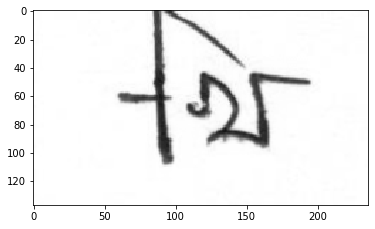

In [3]:
idx = 5
print(str(img_paths[idx]))
img = cv2.imread(str(img_paths[idx]))
plt.imshow(img);

In [4]:
train_df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [5]:
cls_map = pd.read_csv("../input/bengaliai-cv19/class_map.csv")
cls_map.head()

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই


In [6]:
cls_map

,component_type,label,component
0,grapheme_root,0,ং
1,grapheme_root,1,ঃ
2,grapheme_root,2,অ
3,grapheme_root,3,আ
4,grapheme_root,4,ই
...,...,...,...
181,consonant_diacritic,2,র্
182,consonant_diacritic,3,র্য
183,consonant_diacritic,4,্য
184,consonant_diacritic,5,্র


## Check each grapheme

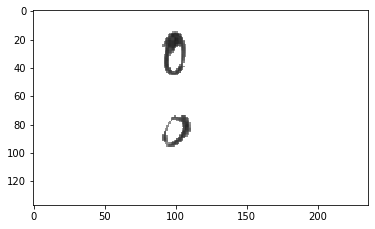

In [50]:
idx = 111
grapheme = 1
grapheme = train_df.query(f"grapheme_root == {grapheme}")
img = cv2.imread(str(img_dir / f'{grapheme.iloc[idx, 0]}.png'))
img[img > 150] = 255
plt.imshow(img);

(0, 20000)

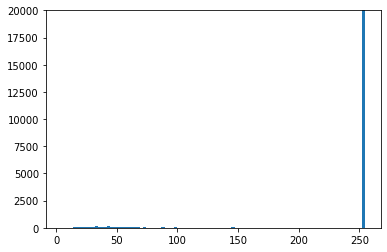

In [36]:
plt.hist(img.reshape(-1), bins=100)
plt.ylim(0, 20000)

## Check preds

In [7]:
preds = np.load("../output/se_resnext.100epoch.size128.cutout/oof_preds.npy")
kf = KFold(random_state=42, n_splits=5, shuffle=True)
splits = list(kf.split(train_df))
val_idx = splits[0][1]
val_preds = preds[val_idx]

In [8]:
val_gt = train_df.loc[val_idx, :]

In [9]:
val_preds

array([[ 71.,   9.,   5.],
       [ 52.,   2.,   0.],
       [ 74.,   1.,   2.],
       ...,
       [ 58.,   9.,   0.],
       [ 65.,   9.,   0.],
       [152.,   9.,   0.]])

In [10]:
val_gt.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
4,Train_4,71,9,5,থ্রো
6,Train_6,52,2,0,ঞ্জি
12,Train_12,74,1,2,র্দ্দা
22,Train_22,53,4,5,ট্রু
31,Train_31,99,1,0,প্না


In [46]:
grapheme_map = cls_map.query(
    "component_type == 'grapheme_root'")[["label", "component"]].set_index("label").to_dict()["component"]
vowel_map = cls_map.query(
    "component_type == 'vowel_diacritic'")[["label", "component"]].set_index("label").to_dict()["component"]
consonant_map = cls_map.query(
    "component_type == 'consonant_diacritic'")[["label", "component"]].set_index("label").to_dict()["component"]

In [54]:
grapheme_preds = val_preds[:, 0]
vowel_preds = val_preds[:, 1]
consonant_preds = val_preds[:, 2]
grapheme_gt = val_gt["grapheme_root"].values
grapheme_component = val_gt["grapheme_root"].map(lambda x: grapheme_map[x]).values

vowel_gt = val_gt["vowel_diacritic"].values
vowel_component = val_gt["vowel_diacritic"].map(lambda x: vowel_map[x]).values

consonant_gt = val_gt["consonant_diacritic"].values
consonant_component = val_gt["consonant_diacritic"].map(lambda x: consonant_map[x]).values

preds_df = pd.DataFrame({
    "image_id": val_gt["image_id"].values,
    "grapheme_preds": grapheme_preds,
    "grapheme_gt": grapheme_gt,
    "grapheme_component": grapheme_component,
    "vowel_preds": vowel_preds,
    "vowel_gt": vowel_gt,
    "vowel_component": vowel_component,
    "consonant_preds": consonant_preds,
    "consonant_gt": consonant_gt,
    "consonant_component": consonant_component,
    "grapheme": val_gt["grapheme"].values
})
preds_df.head()

,image_id,grapheme_preds,grapheme_gt,grapheme_component,vowel_preds,vowel_gt,vowel_component,consonant_preds,consonant_gt,consonant_component,grapheme
0,Train_4,71.0,71,থ,9.0,9,ো,5.0,5,্র,থ্রো
1,Train_6,52.0,52,ঞ্জ,2.0,2,ি,0.0,0,0,ঞ্জি
2,Train_12,74.0,74,দ্দ,1.0,1,া,2.0,2,র্,র্দ্দা
3,Train_22,53.0,53,ট,4.0,4,ু,5.0,5,্র,ট্রু
4,Train_31,99.0,99,প্ন,1.0,1,া,0.0,0,0,প্না


In [56]:
grapheme_failure = preds_df.query("grapheme_preds != grapheme_gt")

In [88]:
grapheme_failure["grapheme_gt"].value_counts()

62     37
122    32
113    25
147    22
53     18
86     18
23     17
29     17
96     16
32     16
56     15
81     15
71     14
13     14
59     14
120    14
115    14
54     13
64     13
22     13
72     13
133    12
85     12
107    11
58     10
18     10
144    10
89     10
150    10
79      9
91      9
153     9
139     9
76      9
148     9
141     9
75      8
152     8
31      8
43      7
65      7
95      7
25      7
167     7
162     7
61      6
103     6
101     6
83      6
116     6
98      5
37      5
118     5
117     5
109     5
119     5
6       5
99      5
28      5
156     5
55      5
142     4
159     4
60      4
135     4
92      4
57      4
94      4
149     4
140     4
16      3
136     3
39      3
143     3
145     3
42      3
38      3
27      3
157     3
15      3
67      3
84      3
68      3
70      3
128     3
127     3
108     3
2       3
10      3
106     3
88      3
9       3
97      3
112     3
35      2
93      2
129     2
146     2
30      2
19      2


In [91]:
grapheme_failure.query("grapheme_gt == 62").grapheme_preds.value_counts()

85.0    15
86.0    14
65.0     2
23.0     1
88.0     1
77.0     1
81.0     1
59.0     1
52.0     1
Name: grapheme_preds, dtype: int64

In [94]:
grapheme_failure.query("grapheme_gt == 62")

,image_id,grapheme_preds,grapheme_gt,grapheme_component,vowel_preds,vowel_gt,vowel_component,consonant_preds,consonant_gt,consonant_component,grapheme
347,Train_1648,85.0,62,ণ্ড,4.0,4,ু,0.0,0,0,ণ্ডু
752,Train_3724,86.0,62,ণ্ড,0.0,0,0,0.0,0,0,ণ্ড
3763,Train_18813,52.0,62,ণ্ড,2.0,2,ি,0.0,0,0,ণ্ডি
6423,Train_32301,85.0,62,ণ্ড,4.0,4,ু,0.0,0,0,ণ্ডু
7453,Train_37398,85.0,62,ণ্ড,0.0,0,0,0.0,0,0,ণ্ড
8869,Train_44483,86.0,62,ণ্ড,0.0,0,0,0.0,0,0,ণ্ড
9978,Train_49896,85.0,62,ণ্ড,1.0,1,া,0.0,0,0,ণ্ডা
10328,Train_51836,86.0,62,ণ্ড,2.0,2,ি,0.0,0,0,ণ্ডি
10967,Train_55057,85.0,62,ণ্ড,7.0,7,ে,0.0,0,0,ণ্ডে
13379,Train_67477,65.0,62,ণ্ড,3.0,3,ী,0.0,0,0,ণ্ডী


In [95]:
grapheme_map[85], grapheme_map[86], grapheme_map[62]

('ন্ড', 'ন্ত', 'ণ্ড')

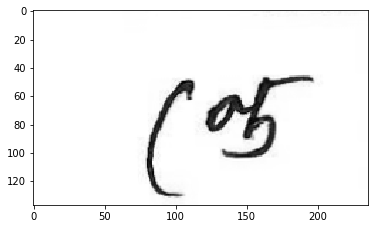

In [103]:
img = cv2.imread(str(img_dir / "Train_104339.png"))
plt.imshow(img);

In [85]:
cls_map.query("component_type == 'grapheme_root' & label == 56")

,component_type,label,component
56,grapheme_root,56,ড


In [75]:
img_ = img[:, :, 0]
img_[img_ > 150] = 255
img_[img_ <= 150] = 0
contours, _ = cv2.findContours(img_, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

,grapheme_preds,grapheme_gt
140,89.0,86
203,107.0,13
313,107.0,13
347,85.0,62
363,70.0,146
...,...,...
39951,147.0,115
40050,133.0,18
40090,125.0,32
40127,56.0,165
